# Assignment 1
**Dylan Osolian & Lisa Samuelsson**

### **Task 1**

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
  
# Read the CSV file.
data = pd.read_csv('./fetal_data.csv', skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency','NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [30]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

clf_dummy = DummyClassifier(strategy='most_frequent')
val_score_dummy = cross_val_score(clf_dummy, Xtrain, Ytrain)
avg_val_dummy = np.average(val_score_dummy)

clf_dt = DecisionTreeClassifier()
val_score_dt = cross_val_score(clf_dt, Xtrain, Ytrain)
avg_val_dt = np.average(val_score_dt)

clf_rf = RandomForestClassifier()
val_score_rf = cross_val_score(clf_rf, Xtrain, Ytrain)
avg_val_rf = np.average(val_score_rf)

clf_gb = GradientBoostingClassifier()
val_score_gb = cross_val_score(clf_gb, Xtrain, Ytrain)
avg_val_gb = np.average(val_score_gb)

clf_p = Perceptron()
val_score_p = cross_val_score(clf_p, Xtrain, Ytrain)
avg_val_p = np.average(val_score_p)

clf_mlp = MLPClassifier()
val_score_mlp = cross_val_score(clf_mlp, Xtrain, Ytrain)
avg_val_mlp = np.average(val_score_mlp)

print(f'Average score for dummy classifier: {round(avg_val_dummy, 4)}')
print(f'Average score for decision tree classifier: {round(avg_val_dt, 4)}')
print(f'Average score for random forest classifier: {round(avg_val_rf, 4)}')
print(f'Average score for gradient boosting classifier: {round(avg_val_gb, 4)}')
print(f'Average score for perceptron: {round(avg_val_p, 4)}')
print(f'Average score for MLP classifier: {round(avg_val_mlp, 4)}')

Average score for dummy classifier: 0.7806
Average score for decision tree classifier: 0.9218
Average score for random forest classifier: 0.9359
Average score for gradient boosting classifier: 0.9488
Average score for perceptron: 0.8253
Average score for MLP classifier: 0.8894


We decided to test the classifiers decision tree, random forest, gradient boosting, perceptron and MLP. We found that the classifiers random forest and gradient boosting gave the highest accuracies, and decided to use the random forest classifier on the whole test set. A random forest is an ensemble of decision trees. The purpose of using a random forest instead of a single decision tree is to create a more robust model by combining the result of each tree. It also helps prevent overfitting. 

The accuracy of this model on the whole test set became around 93%

In [31]:
from sklearn.metrics import accuracy_score
  
clf_rf.fit(Xtrain, Ytrain)
Yguess = clf_rf.predict(Xtest)

print(f'Average score for the random forest classifier on the full test set: {round(accuracy_score(Ytest, Yguess), 4)}')

Average score for the random forest classifier on the full test set: 0.9225


### **Task 2**

#### **Decision Tree Classes**


In [32]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

    
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

### **Decision trees for classification**

In the code cell below we are tuning the hyperparameter using cross validation on the training set. 

In [33]:
# tuning hyperparameter using cross validation
max_score = 0
max_score_depth = 0

for depth in range(1, 30):
    clf = TreeClassifier(max_depth=depth)

    cv_score = cross_val_score(clf, Xtrain, Ytrain)
    mean_cv_score = np.mean(cv_score)

    if mean_cv_score >= max_score:
        max_score = mean_cv_score
        max_score_depth = depth

        
print(f'Maximum accuracy score: {round(max_score, 4)} at depth {max_score_depth}')

Maximum accuracy score: 0.9135 at depth 13


We selected the max depth to be 13, as it gave us the best cross validation performance. 
On the test set this gave us an accuracy of around 87%. See image of the tree by running the cell below. 

Accuracy score: 0.8732


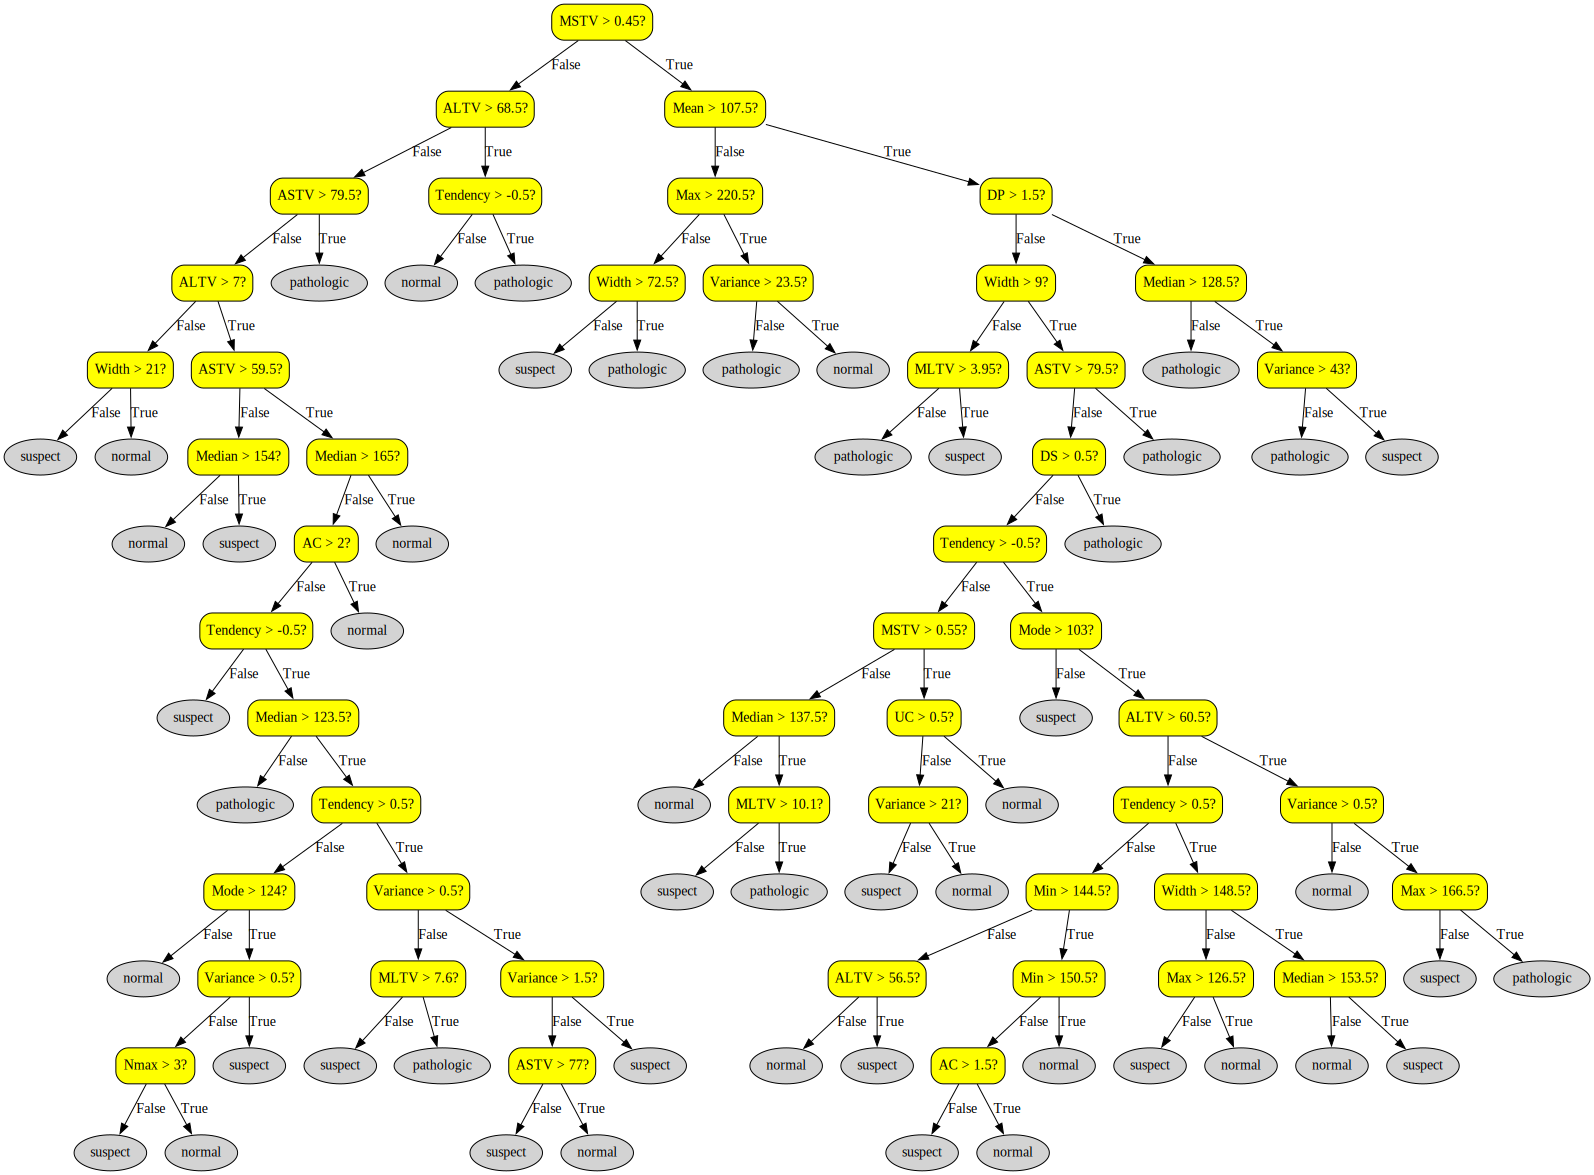

In [34]:
clf_decision_tree = TreeClassifier(max_depth=13)

clf_decision_tree.fit(Xtrain, Ytrain)
Yguess = clf_decision_tree.predict(Xtest)
print(f'Accuracy score: {round(accuracy_score(Ytest, Yguess), 4)}')

clf_decision_tree.draw_tree()

### **Task 3**

In [35]:
# Read the CSV file using Pandas.
alldata = pd.read_csv('./house_data.csv')

alldata.head()

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]

alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)

# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)


In [36]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

m1 = DummyRegressor()
cv_dr = cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')

lr = LinearRegression()
cv_lr = cross_validate(lr, Xtrain, Ytrain, scoring='neg_mean_squared_error')

ridge = Ridge()
cv_r = cross_validate(ridge, Xtrain, Ytrain, scoring='neg_mean_squared_error')

lasso = Lasso()
cv_l = cross_validate(lasso, Xtrain, Ytrain, scoring='neg_mean_squared_error')

dtr = DecisionTreeRegressor()
cv_dtr = cross_validate(dtr, Xtrain, Ytrain, scoring='neg_mean_squared_error')

rfr = RandomForestRegressor()
cv_rfr = cross_validate(rfr, Xtrain, Ytrain, scoring='neg_mean_squared_error')

gbr = GradientBoostingRegressor()
cv_gbr = cross_validate(gbr, Xtrain, Ytrain, scoring='neg_mean_squared_error')

mlp = MLPRegressor()
cv_mlp = cross_validate(mlp, Xtrain, Ytrain, scoring='neg_mean_squared_error')

print(f'Average negative mean squared error for dummy regressor: {round(np.average(cv_dr["test_score"]), 4)}')
print(f'Average negative mean squared error for linear regressor: {round(np.average(cv_lr["test_score"]), 4)}')
print(f'Average negative mean squared error for ridge: {round(np.average(cv_r["test_score"]), 4)}')
print(f'Average negative mean squared error for lasso: {round(np.average(cv_l["test_score"]), 4)}')
print(f'Average negative mean squared error for decision tree regressor: {round(np.average(cv_dtr["test_score"]), 4)}')
print(f'Average negative mean squared error for random forest regressor: {round(np.average(cv_rfr["test_score"]), 4)}')
print(f'Average negative mean squared error for gradient boosting regressor: {round(np.average(cv_gbr["test_score"]), 4)}')
print(f'Average negative mean squared error for MLP regressor: {round(np.average(cv_mlp["test_score"]), 4)}')


Average negative mean squared error for dummy regressor: -0.3893
Average negative mean squared error for linear regressor: -0.3014
Average negative mean squared error for ridge: -0.3014
Average negative mean squared error for lasso: -0.301
Average negative mean squared error for decision tree regressor: -0.5257
Average negative mean squared error for random forest regressor: -0.2846
Average negative mean squared error for gradient boosting regressor: -0.2646
Average negative mean squared error for MLP regressor: -418.96


In [37]:
from sklearn.metrics import mean_squared_error
  
gbr.fit(Xtrain, Ytrain)

ms_error = round(mean_squared_error(Ytest, gbr.predict(Xtest)), 4)
print(f'Average mean squared error for test set: {ms_error}')

Average mean squared error for test set: 0.2714


We selected the gradient boosting regressor, which reached a mean squared error of 0.27. The gradient boosting regressor is an ensemble of decision trees which uses gradient descent. 

### **Task 4**

In [38]:
from sklearn.base import RegressorMixin

class TreeRegressor(DecisionTree, RegressorMixin):

    def __init__(self, max_depth):
        super().__init__(max_depth)

    def fit(self, X, Y):
        return super().fit(X, Y)

    def get_default_value(self, Y):
        return np.mean(Y)

    def is_homogeneous(self, Y):
        # compare variance to (hardcoded) threshold value
        threshold = 0.001
        return np.var(Y) < threshold

    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)
        
        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        total_var = np.var(Y_sorted)
        
        sum_of_sq_low = 0
        sum_low = 0

        sum_of_sq_high = sum(np.square(Y_sorted))
        sum_high = sum(Y_sorted)
        
        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # split the data into two parts
            low_distr = Y_sorted[0:i+1]            
            high_distr = Y_sorted[i+1:n]

            # keep tracks of the sums for the two partitions
            sum_low = sum_low + y_i
            sum_of_sq_low = sum_of_sq_low + pow(y_i, 2)

            sum_of_sq_high = sum_of_sq_high - pow(y_i, 2)
            sum_high = sum_high - y_i 

            n_h = len(high_distr)
            n_l = len(low_distr)

            # If the input is equal to the input at the next position, we will
            # not consider a split here.    
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # calculate the score by using variance reduction
            score = total_var - (n_h/n) * calc_variances(n_h, sum_high, sum_of_sq_high) - (n_l/n) * calc_variances(n_l, sum_low, sum_of_sq_low)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

def draw_tree(self):
    graph = Digraph()
    self.root.draw_tree(graph, 0, self.names)
    return graph

# calculate variance with given formula
def calc_variances(n, sumx, sum_of_sq):
    return 1/n * sum_of_sq - 1/(n*n) * sumx**2


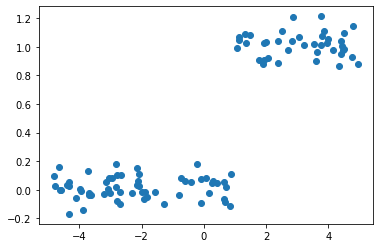

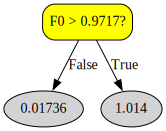

In [39]:
import matplotlib.pyplot as plt

def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

X_data, Y_data = make_some_data(100)

plt.scatter(X_data, Y_data)
plt.show()

trg = TreeRegressor(1)
trg.fit(X_data,Y_data)
trg.draw_tree()

 **Train your decision tree regressor algorithm on a small dataset generated by the function above, and then draw the tree. Select the tree depth according to your common sense. Does the result make sense? What happens if we allow the tree depth to be a large number?**

In the test data we see that there are two quite distinct classes, and we therefore selected a tree depth of 1, and the result makes sense. If the x value is larger than approximately 1.2, then we end up in the right cluster, and otherwise we end up in the left cluster. If the tree depth is allowed to be a larger number, we will still get the same result, and this is due to our variance threshold. If we would have selected a smaller number as our threshold then we could have gotten a tree with larger depth which in this case would probably be overfitting.  


In [40]:
trg = TreeRegressor(6)
cv = cross_validate(trg, Xtrain, Ytrain, scoring='neg_mean_squared_error')

print(f'Mean value for cross validation mean squared error: { round(np.mean(cv["test_score"]), 4)} ')

Mean value for cross validation mean squared error: -0.2804 


Mean square error of tree regressor (using max depth = 6): 0.2862


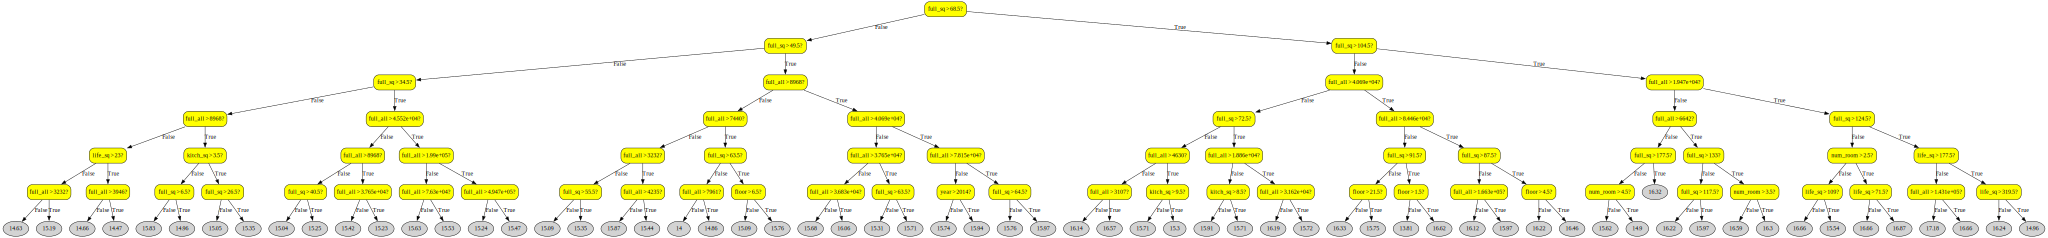

In [41]:
from sklearn.metrics import mean_squared_error
trg = TreeRegressor(6)

trg.fit(Xtrain, Ytrain)

ms_error = mean_squared_error(Ytest, trg.predict(Xtest))

print(f'Mean square error of tree regressor (using max depth = 6): {round(ms_error, 4)}')
trg.draw_tree()

In [42]:
train_scores = []
test_scores = []
for x in range(13):
    trg = TreeRegressor(x)
    trg.fit(Xtrain, Ytrain)
    train_scores.append(mean_squared_error(Ytrain, trg.predict(Xtrain)))
    test_scores.append(mean_squared_error(Ytest, trg.predict(Xtest)))

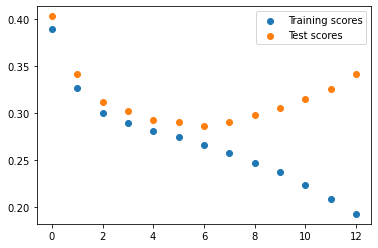

In [43]:
plt.scatter(np.arange(0,13), train_scores, label = "Training scores")
plt.scatter(np.arange(0,13), test_scores, label = "Test scores")
plt.legend()
plt.show()

Looking at the scores for the training set we can see that when we increase the max depth of the tree we get better (lower) scores. However, the scores for the test set get worse as the depth of the tree increases. This is due to overfitting the model to the training set. For higher maximum depths the generalization gap increases. When the max depths are small the model performs poorly, and this is likely due to underfitting as the model is not able to capture all the information. We set the max depth to 6, and we believe that this is a good number as it is a good compromise between a small generalization gap and a good score. 